In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

import random
import cmath
import matplotlib.mlab as mlab
from scipy.stats import norm

# notes on comments: Q - Questions, A - Attention (to do, to pay attention to)

np.random.seed(8)

In [2]:
# BASIC FUNCTIONS

# lif neuron with noise (Gaussian)
def LIF_step_noise(voltage, tau, current, dt, threshold, voltage_rest, resistance, std_noise):
    if voltage < threshold:
        return (- voltage + current * resistance + voltage_rest) * dt / tau + voltage + np.random.normal(0, std_noise, 1)
    else:
        return voltage_rest + np.random.normal(0, std_noise, 1)
    
#grad decent (real numbers), quadratic error function, target function: product
def weight_update(weights, x, y, mu): 
    #mu learning rate
    return weights + 2 * mu * (y - np.dot(weights, x)) * x

#grad decent (real numbers), quadratic error function, target function: sum
def delay_update_2(delays, x, y, mu): 
    #shape of delays: (neurons,)
    #mu learning rate
    return delays + 2 * mu * (y - (x + delays)) #ATTENTION: Y is a scalar, x and delays are vectors (but it works)!!!

#(complex) phase
def convert_phase(T, t):
    return math.pi * t / (T * 2) 

# time from (complex) phase
def convert_phase_back(T, phi):
    return phi * 2 * t_max / math.pi

#complex exponential for arrays
def convert_exp(array): 
    res = np.zeros(len(array), dtype=np.complex_)
    for a in range(len(array)):
        res[a] = cmath.exp(array[a])
    return res

In [3]:
# PARAMETER SETTINGS

#lif neuron
dt = 0.001
tau = 5 
threshold = -40 
voltage_rest = -70
resistance = 1
std_noise = 0.01 #std Gaussian LIF neuron noise
learning_rate = 0.1 

#data set
neurons = 50
t_max = 10

In [4]:
# DATA SET X (BASIC PATTERN ASSIGNED RANDOMLY)
# creates one 'basic pattern' and adds some noise on top (to get train/test data)

# Q: normalization of the weights (as they correspond to prob)
# A: Gaussian: long tails (overlap intervals, neg weights), by 'chance' two spikes at the same time
# A: negative real weights not allowed 

def data(neurons, t_max, size, std_jitter, max_var_p):
    # neurons: number of neurons
    # size: size of the whole data set
    # t_max: length of one time interval
    # std_jitter / std_p: noise parameters 
    collect_delays = np.zeros((neurons, size))
    collect_weights = np.zeros((neurons, size))
    X_delays = np.random.uniform(0, t_max, neurons) #arbitrary 'spike pattern' - 'basis'
    X_weights = np.ones(neurons) #np.random.uniform(0.5, 1, neurons) -- 'weight of input' (equals the probability of the neurons to 'add their spike pattern to input LIF')
    var_p = np.random.uniform(0, max_var_p, neurons) #individual std jitter prob. neurons (constant for whole data set)
    for a in range(size):
        jitter = np.random.normal(0, std_jitter, neurons) #not yet truncated! (change to uniform?!)
        jitter_2 = np.zeros(neurons)
        for b in range(neurons):
            jitter_2[b] = np.random.normal(0, var_p[b], 1)
        collect_delays[:, a] = X_delays + jitter
        collect_weights[:, a] = X_weights + jitter_2
        collect_weights[:, a] = [0 if i < 0 else i for i in collect_weights[:, a]] # truncate real weights for neg values
        
    return collect_delays, collect_weights, X_delays, X_weights, var_p
    
    
# DESIRED OUTPUT O 

# Q: supervised learning (but 'label' is arbitraryly set)

Y_delay = 12 #desired postsyn spike time, arbitrarily set to a value greater than t_max
Y_weight = abs(threshold - voltage_rest)

In [5]:
#DATA SET X - CONVERT TO COMPLEX NUMBERS 

def data_complex(neurons, X_delays, X_weights):
    # input: the basic pattern generated in function data
    complex_X = np.zeros((neurons, 1), dtype=np.complex_) # (neurons, 1) to make module 1 work
    for a in range(neurons):
        complex_X[a, 0] = cmath.exp(complex(0, 1) * convert_phase(t_max, X_delays[a])) * X_weights[a]
    return complex_X
        
# DESIRED OUTPUT 0

complex_Y = cmath.exp(complex(0, 1) * convert_phase(t_max, Y_delay)) * Y_weight

In [6]:
# MODULE 2 - TRAINING DELAYS AND WEIGHTS FOR THE GIVEN PATTERN

def module_2 (X_pattern, X_weight, Y, Y_weight, learning_rate, iterations, neurons):
    d_evolution = np.zeros((neurons, iterations, 2))
    for a in range(iterations):
        if a > 0:
            #learning rate needs to be adapted to number of neurons (for weights), otherwise no convergence (e.g. oscillations for too high rates)
            d_evolution[:, a, 0] = delay_update_2(d_evolution[:, a - 1, 0], X_pattern, Y, learning_rate)
            d_evolution[:, a, 1] = weight_update(d_evolution[:, a - 1, 1], X_weight, Y_weight, learning_rate / neurons)
    return d_evolution

def module_2_2 (X_pattern, X_weight, Y, Y_weight, learning_rate, iterations, neurons):
    d_evolution = np.zeros((neurons, iterations + 1, 2))
    for a in range(iterations + 1):
        if a > 0:
            d_evolution[:, a, 0] = delay_update_2(d_evolution[:, a - 1, 0], X_pattern[:, a], Y, learning_rate)
            d_evolution[:, a, 1] = weight_update(d_evolution[:, a - 1, 1], X_weight[:, a], Y_weight, learning_rate / neurons)
    return d_evolution

49999


/home/laura/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


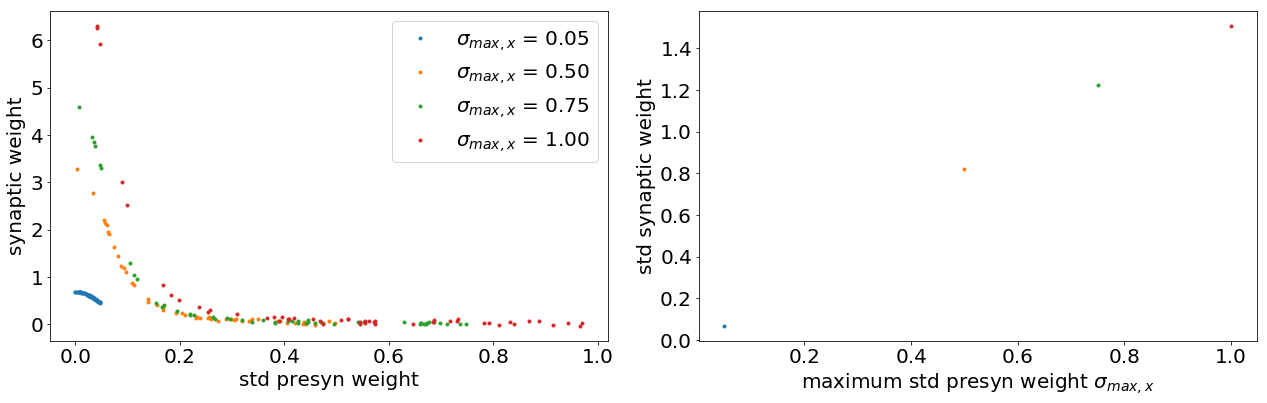

In [7]:
# TEST MODULE 2 AND VISUALIZE OUTPUT

plt.figure(figsize = (18,6))
plt.rcParams.update({'font.size': 20}) #change font size for figures

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

size_dataset = 50000 # converges very slow
training = 1.0
iterations = int(size_dataset * training) - 1 #one iteration grad decent per training example
print(iterations)

std = [0.05, 0.5, 0.75, 1]
store_std = np.zeros((neurons, 2, len(std)))

for a in range(len(std)):
    delays, weights, basic_delay, basic_weight, std_neurons_p = data(neurons, t_max, size_dataset, 0.0, std[a])
    result = module_2_2(delays, weights, Y_delay, Y_weight, learning_rate, iterations, neurons)
    store_std[:, 0, a] = std_neurons_p
    store_std[:, 1, a] = result[:, iterations, 1]

for i in range(len(std)):
    plt.subplot(1, 2, 1)
    plt.plot(store_std[:, 0, i], store_std[:, 1, i], '.', label = r'$\sigma_{max, x}$ = %.2f' % std[i])
    plt.ylabel('synaptic weight')
    plt.xlabel('std presyn weight')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(std[i], np.std(store_std[:, 1, i]), '.')
    plt.xlabel(r'maximum std presyn weight $\sigma_{max, x}$')
    plt.ylabel('std synaptic weight')
    
plt.tight_layout()
#plt.savefig('weights_pre_synaptic_2.pdf')
plt.show()

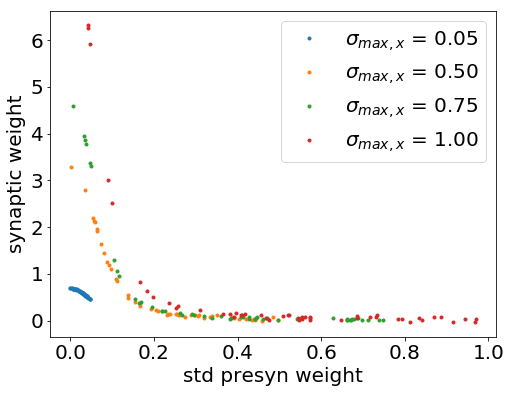

In [8]:
plt.figure(figsize = (8,6))
plt.rcParams.update({'font.size': 20}) #change font size for figures

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

for i in range(len(std)):
    plt.plot(store_std[:, 0, i], store_std[:, 1, i], '.', label = r'$\sigma_{max, x}$ = %.2f' % std[i])
    plt.ylabel('synaptic weight')
    plt.xlabel('std presyn weight')
    plt.legend()
    
#plt.savefig('weights_pre_synaptic.pdf')
plt.show()